# Daniel Gabrieli

In [1]:
import re
import pandas as pd
idx = pd.IndexSlice
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

In [2]:
pd.__version__

'0.18.0'

In [3]:
DATES = ['140104', '131228', '131221', '131214', '131207', '131130', '131123', '131116', '131109', '131102',
         '131026', '131019', '131012', '131005', '130928', '130921', '130914', '130907', '130831', '130824',
         '130817', '130810', '130803', '130727', '130720', '130713', '130706', '130629', '130622', '130615',
         '130608', '130601', '130525', '130518', '130511', '130504', '130427', '130420', '130413', '130406',
         '130330', '130323', '130316', '130309', '130302', '130223', '130216', '130209', '130202', '130126',
         '130119', '130112', '130105', '121229', '121222', '121215', '121208', '121201', '121124', '121117',
         '121110', '121103', '121027', '121020', '121013', '121006', '120929', '120922', '120915', '120908',
         '120901', '120825', '120818', '120811', '120804', '120728', '120721', '120714', '120707', '120630',
         '120623', '120616', '120609', '120602', '120526', '120519', '120512', '120505', '120428', '120421',
         '120414', '120407', '120331', '120324', '120317', '120310', '120303', '120225', '120218', '120211',
         '120204', '120128', '120121', '120114', '120107', '111231']

#URL = 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt'
#URLS = [URL.format(date) for date in DATES]
#META = pd.read_excel('http://web.mta.info/developers/resources/nyct/turnstile/Remote-Booth-Station.xls')
#META = META.rename_axis({'Booth': 'CA', 'Remote': 'UNIT'},axis=1)
#META.to_pickle('meta.pkl')
META = pd.read_pickle('meta.pkl')

In [4]:
def get_data(urls):
    df_list = []
    error_list = []
    for url in urls:
        try:
            print('getting data from url: {}'.format(url))
            df_list.append(read_and_clean(url))
        except Exception as e:
            print('error with: {}'.format(url))
            error_list.append(url)
    return df_list, error_list

def read_and_clean(url):
    DTYPES = {'CA': 'object', 'UNIT': 'object', 'SCP': 'object', 'DATE1': 'object', 'TIME1': 'object', 'DESC1': 'object', 'ENTRIES1': 'int64', 'EXITS1': 'int64', 'DATE2': 'object', 'TIME2': 'object', 'DESC2': 'object', 'ENTRIES2': 'float64', 'EXITS2': 'float64', 'DATE3': 'object', 'TIME3': 'object', 'DESC3': 'object', 'ENTRIES3': 'float64', 'EXITS3': 'float64', 'DATE4': 'object', 'TIME4': 'object', 'DESC4': 'object', 'ENTRIES4': 'float64', 'EXITS4': 'float64', 'DATE5': 'object', 'TIME5': 'object', 'DESC5': 'object', 'ENTRIES5': 'float64', 'EXITS5': 'float64', 'DATE6': 'object', 'TIME6': 'object', 'DESC6': 'object', 'ENTRIES6': 'float64', 'EXITS6': 'float64', 'DATE7': 'object', 'TIME7': 'object', 'DESC7': 'object', 'ENTRIES7': 'float64', 'EXITS7': 'float64', 'DATE8': 'object', 'TIME8': 'object', 'DESC8': 'object', 'ENTRIES8': 'float64', 'EXITS8': 'float64'}
    header_old = ['CA','UNIT','SCP','DATE1','TIME1','DESC1','ENTRIES1','EXITS1','DATE2','TIME2','DESC2','ENTRIES2','EXITS2','DATE3','TIME3','DESC3','ENTRIES3','EXITS3','DATE4','TIME4','DESC4','ENTRIES4','EXITS4','DATE5','TIME5','DESC5','ENTRIES5','EXITS5','DATE6','TIME6','DESC6','ENTRIES6','EXITS6','DATE7','TIME7','DESC7','ENTRIES7','EXITS7','DATE8','TIME8','DESC8','ENTRIES8','EXITS8']
    df = pd.read_table(url, sep=',', names=header_old, header=None, engine='c', dtype=DTYPES)
    df = (df.pipe(fix_pre_20141018)
            .pipe(make_datetime)
            .merge(META, how='inner',on=['CA','UNIT'])
            .pipe(make_turnstile_id)
            .drop(['CA', 'UNIT', 'SCP'], axis=1)
            .sort_values(['DATETIME', 'TSTILE'])
            .set_index(['DATETIME', 'TSTILE']))
    df = df[df.DESC == 'REGULAR']  #  subset to REGULAR only
    df = df[(df.ENTRIES >= 0) & (df.EXITS >= 0)]  # drop errors
    diff = df.groupby(level=['TSTILE']).diff()
    diff_gte0 = diff[(diff.ENTRIES >= 0) & (diff.EXITS >= 0)]  # drop errors
    df = df.join(diff_gte0, how='inner', rsuffix='_DIFF').drop(['DESC', 'DATE', 'TIME'], axis=1)
    df['BUSYNESS'] = df.ENTRIES_DIFF + df.EXITS_DIFF
    df.columns = [col.replace(' ', '').strip().upper() for col in df.columns]
    df = df.sort_index()
    return df

def fix_pre_20141018(df):
    """MTA turnstile .txt files before 20141018 have a strange format.
    This function makes that format the same as the post 20141018 format
    station_lookup is a csv file that can find station name based on ('C/A', UNIT, SCP)
    """
    result = []
    splits = ["""CA,UNIT,SCP,DATE{index},TIME{index},DESC{index},ENTRIES{index},EXITS{index}""".format(index=i).split(',') for i in range(1,9)]
    clean_column_names = ['CA','UNIT','SCP','DATE','TIME','DESC','ENTRIES','EXITS']
    for split in splits:
        temp = df[split]
        temp.columns = clean_column_names
        result.append(temp)
    df_long = pd.concat(result)
    return df_long

def make_datetime(df):
    """concat the date and time columns into one"""
    df['DATETIME'] =  pd.to_datetime(df['DATE']+df['TIME'], format='%m-%d-%y%H:%M:%S')
    return df

def make_turnstile_id(df):
    icols = ['CA','UNIT','SCP', 'STATION']
    df['TSTILE'] = df[icols].apply(lambda x: '_'.join(x), axis=1)
    return df    

Cleaning
- Drop rows with NA
- Drop non-REGULAR readings
- Drop negative readings
- Drop rows where the diff between row_n and rown_n+1 is negative
  - The diff represents the incremental increase in turnstile use; thus it should only be negative when the odometer resets

Load and Clean Data

In [5]:
try:
    df = pd.read_pickle('./data.pkl')
    df = df.sort_index()
except:
    df_list, error_list = get_data(URLS)
    df = pd.concat(df_list)
    df = df.sort_index() # this needs to be here
    df.to_pickle('./data.pkl')

In [6]:
df = df.set_index('STATION', append=True)
df['zscore'] = df.groupby(level='STATION')['BUSYNESS'].transform(lambda x: pd.np.abs((x - x.mean()))/x.std())


Use Z-Score to remove outliers
-----

In [7]:
df = df[df.zscore < 10]

# Data Analysis:

Which station has the most number of (remote) units?
------
  - '34 ST-PENN STA'  has the most number of Remote Units at 14
  - '86 ST' and 'CANAL ST' are tied for the most number of unique remote units at 5 each
     

In [8]:
META.groupby('Station')['UNIT'].count().sort_values(ascending=False)[0:3]

Station
34 ST-PENN STA    14
FULTON ST         12
86 ST             10
Name: UNIT, dtype: int64

In [9]:
META.groupby('Station')['UNIT'].nunique().sort_values(ascending=False)[0:3]

Station
86 ST             5
CANAL ST          5
34 ST-PENN STA    4
Name: UNIT, dtype: int64

In [10]:
aug1 = df.loc[idx[pd.datetime(2013,8,1,0,0,0):pd.datetime(2013,8,1,23,59,59)],:] 

What is the total number of entries & exits across the subway system for August 1, 2013?
------

In [11]:
aug1['BUSYNESS'].sum()

10025627.0

Let’s define the busy-ness as sum of entry & exit count. What station was the busiest on August 1, 2013?
------

In [12]:
aug1.groupby(level='STATION')['BUSYNESS'].sum().sort_values(ascending=False)[:1]

STATION
34 ST-PENN STA    332241.0
Name: BUSYNESS, dtype: float64

What turnstile was the busiest on that date?
------

In [13]:
aug1.groupby(level='TSTILE')['BUSYNESS'].sum().sort_values(ascending=False)[:1]

TSTILE
N063A_R011_00-00-00    11786.0
Name: BUSYNESS, dtype: float64

What stations have seen the most usage growth/decline in 2013?
------

In [14]:
# slope of the cumulative sum?
# df = df.set_index('STATION',append=True)
gb_A_station = [pd.Grouper(level='DATETIME', freq='A'), pd.Grouper(level='STATION')]
usage = df.groupby(gb_A_station)['BUSYNESS'].sum().groupby(level='STATION').pct_change().dropna()['2013-12-31'].sort_values()

In [15]:
usage[:3]

STATION
63 DR-REGO PARK   -0.561345
GROVE STREET      -0.374965
CENTRAL AVE       -0.111306
dtype: float64

In [16]:
usage[-3:]

STATION
KNICKERBOCKER        4.007143
ZEREGA AVE           7.150691
AQUEDUCT TRACK    2427.347826
dtype: float64

What dates are the least busy?
------

In [17]:
df.groupby([pd.Grouper(level='DATETIME', freq='D')])['BUSYNESS'].sum().sort_values()[:3]

DATETIME
2012-10-30    13052.0
2012-10-31    19524.0
2012-10-29    22758.0
Name: BUSYNESS, dtype: float64

Could you identify days on which stations were not operating at full capacity or closed entirely?
------
  - I'm reinterpreting this as 'identify the 3 least least busy days by station'


In [18]:
df.groupby([pd.Grouper(level='DATETIME', freq='D'), pd.Grouper(level='STATION')])['BUSYNESS'].sum().groupby(level='STATION').nsmallest(3)

STATION          DATETIME    STATION        
1 AVE            2012-10-29  1 AVE                39.0
                 2013-11-16  1 AVE                59.0
                 2013-11-17  1 AVE                64.0
103 ST           2012-10-29  103 ST               10.0
                 2012-10-30  103 ST               18.0
                 2012-10-31  103 ST               31.0
103 ST-CORONA    2012-11-01  103 ST-CORONA        26.0
                 2012-10-29  103 ST-CORONA        28.0
                 2012-10-31  103 ST-CORONA        54.0
104 ST           2012-10-14  104 ST                0.0
                 2013-06-02  104 ST                0.0
                 2012-11-02  104 ST                1.0
110 ST           2012-10-30  110 ST                3.0
                 2012-10-29  110 ST               17.0
                 2012-10-31  110 ST               59.0
110 ST-CATHEDRL  2012-10-30  110 ST-CATHEDRL      13.0
                 2012-10-31  110 ST-CATHEDRL      23.0
                 201

 

## Visualization:

In [19]:
df = df.sort_index()
Q3 = df.loc[idx[pd.datetime(2013,7,1):pd.datetime(2013,9,30,23,59,59)],]

Plot the daily row counts for data files in Q3 2013.
-------

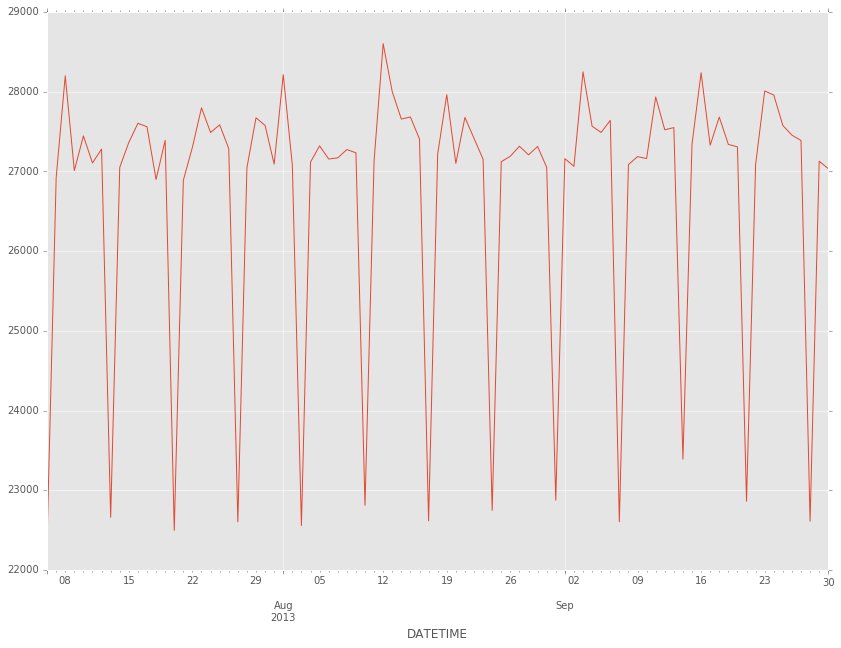

In [20]:
row_counts = Q3.groupby([pd.Grouper(level='DATETIME', freq='D')]).apply(lambda x: len(x)).copy()
row_counts.plot(figsize=(14,10))

Plot the daily total number of entries & exits across the system for Q3 2013.
----

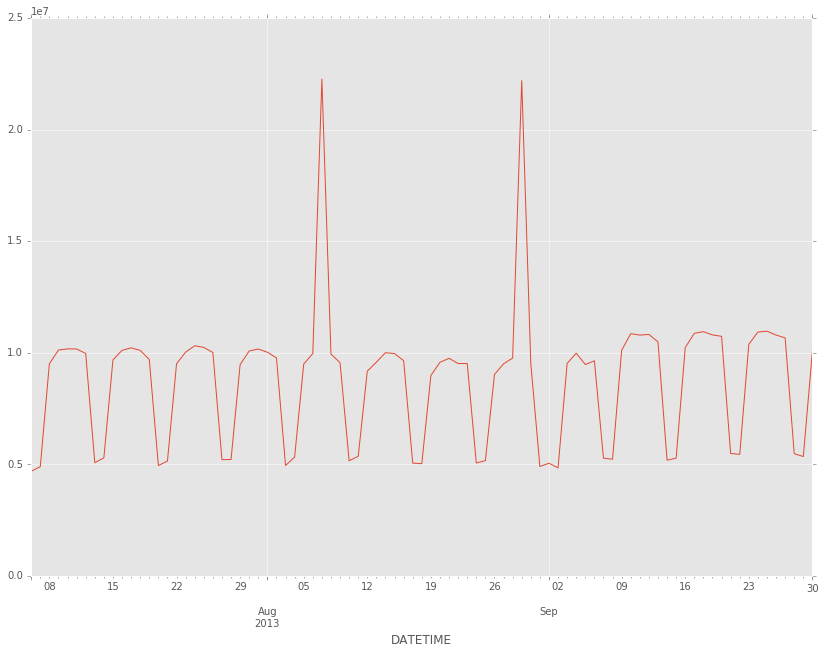

In [21]:
total_busyness = Q3.groupby([pd.Grouper(level='DATETIME', freq='D')])['BUSYNESS'].sum().copy()
total_busyness.plot(figsize=(14,10))

Plot the mean and standard deviation of the daily total number of entries & exits for each month in Q3 2013 for station 34 ST-PENN STA.
-------

In [87]:
MeanQ3Penn = (Q3.groupby([pd.Grouper(level='DATETIME', freq='D'), pd.Grouper(level='STATION')])
     .sum()
     .xs('34 ST-PENN STA', level='STATION')['BUSYNESS']
     .groupby([pd.Grouper(level='DATETIME', freq='M')])
     .agg(pd.np.mean))

StdQ3Penn = (Q3.groupby([pd.Grouper(level='DATETIME', freq='D'), pd.Grouper(level='STATION')])
     .sum()
     .xs('34 ST-PENN STA', level='STATION')['BUSYNESS']
     .groupby([pd.Grouper(level='DATETIME', freq='M')])
     .agg(pd.np.std))



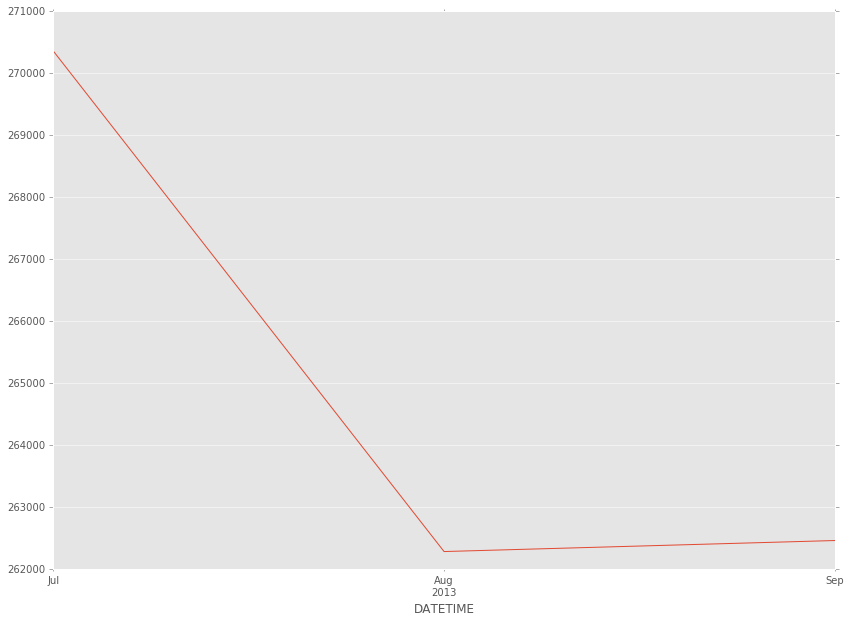

In [90]:
MeanQ3Penn.plot(figsize=(14,10))

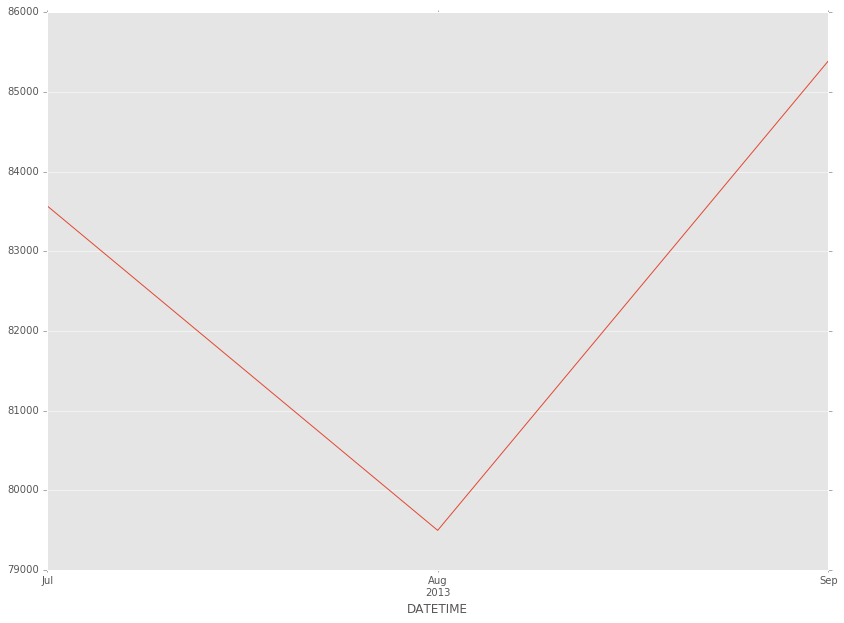

In [88]:
StdQ3Penn.plot(figsize=(14,10))

Plot 25/50/75 percentile of the daily total number of entries & exits for each month in Q3 2013 for station 34 ST-PENN STA.
------

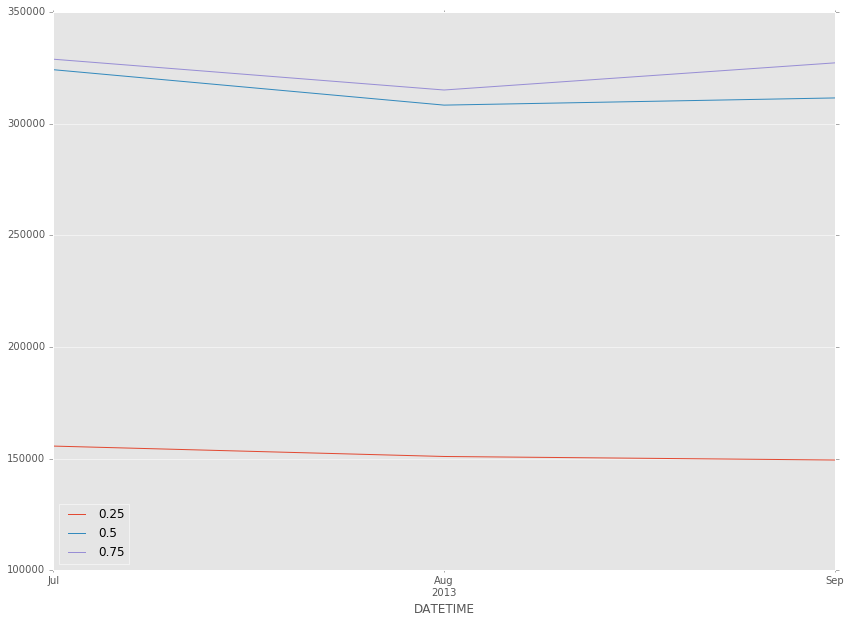

In [82]:
(Q3.groupby([pd.Grouper(level='DATETIME', freq='D'), pd.Grouper(level='STATION')])
     .sum()
     .xs('34 ST-PENN STA', level='STATION')['BUSYNESS']
     .groupby([pd.Grouper(level='DATETIME', freq='M')])
     .quantile([.25, .50, .75])
     .unstack(1)
     .plot(figsize=(14,10)))

Plot the daily number of closed stations and number of stations that were not operating or had zero traffic in Q3 2013.
------

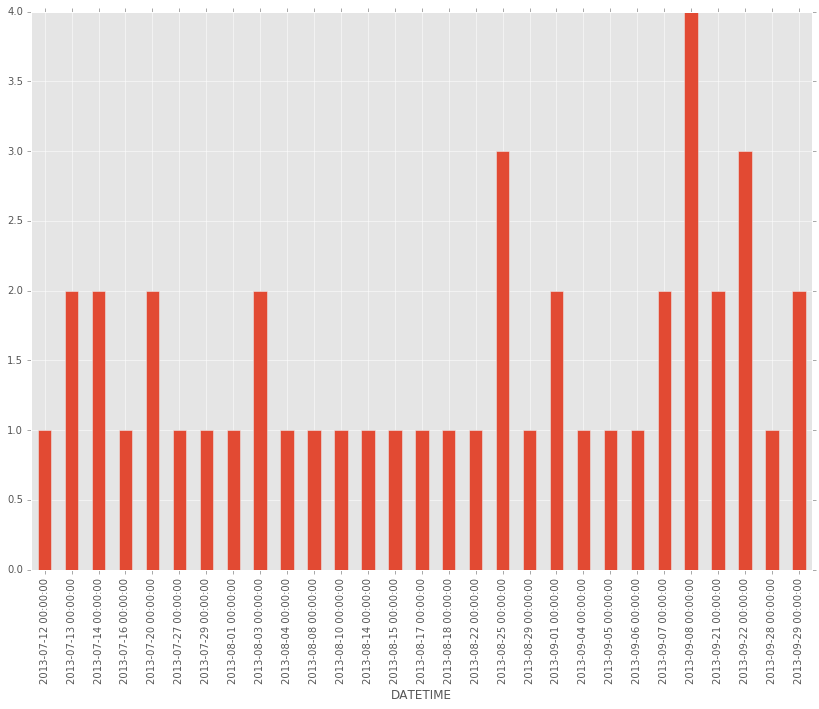

In [80]:
closed_stations = Q3.groupby([pd.Grouper(level='DATETIME', freq='D'), pd.Grouper(level='STATION')])['BUSYNESS'].sum()
closed_stations = closed_stations[closed_stations == 0]
closed_stations.groupby([pd.Grouper(level='DATETIME', freq='D')]).count().plot.bar(figsize=(14,10))

In [76]:
closed_stations

DATETIME    STATION        
2013-07-12  ORCHARD BEACH      0.0
2013-07-13  AQUEDUCT TRACK     0.0
            VAN ALSTON-21ST    0.0
2013-07-14  AQUEDUCT TRACK     0.0
            VAN ALSTON-21ST    0.0
2013-07-16  AQUEDUCT TRACK     0.0
2013-07-20  AQUEDUCT TRACK     0.0
            VAN ALSTON-21ST    0.0
2013-07-27  MURRAY ST-B'WAY    0.0
2013-07-29  ORCHARD BEACH      0.0
2013-08-01  ORCHARD BEACH      0.0
2013-08-03  ORCHARD BEACH      0.0
            VAN ALSTON-21ST    0.0
2013-08-04  VAN ALSTON-21ST    0.0
2013-08-08  ORCHARD BEACH      0.0
2013-08-10  VAN ALSTON-21ST    0.0
2013-08-14  ORCHARD BEACH      0.0
2013-08-15  ORCHARD BEACH      0.0
2013-08-17  VAN ALSTON-21ST    0.0
2013-08-18  191 ST             0.0
2013-08-22  ORCHARD BEACH      0.0
2013-08-25  FOREST AVE         0.0
            KNICKERBOCKER      0.0
            SENECA AVE         0.0
2013-08-29  ORCHARD BEACH      0.0
2013-09-01  EUCLID AVE         0.0
            WILSON AVE         0.0
2013-09-04  ORCHARD BEACH  